In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import math
import os
import sys
import shutil
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functions_analyze as lib
from scipy.signal import find_peaks

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [3]:
def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a = None, coeff_rep = None):
    """
    Calculate the force field within the focal box.

    Parameters
    ----------
    - coordinates_diff: Tensor representing the positions of particles in the focal box.

    Returns
    -------
    - force_field: Tensor representing the force field within the focal box.

    """  
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # prevents the repulsion force from exploding when approaching its maximum value
    R = torch.where(R > Rlim*torch.ones(1, device=device),
                  R, Rlim*torch.ones(1, device=device)).to(device)
    
    ###########  R**2 adhesion force ###########
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(a*R**2+b*R+c), torch.zeros_like(R)).to(device)
    
    ########### a*R**alpha + b ############
    alpha = coeff_a
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(Fadh/((R0**alpha)-(Req**alpha)))*((R**alpha)-(Req**alpha)), torch.zeros_like(R)).to(device)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        function_adh(R, Req, R0, Fadh, alpha, coeff_a=coeff_a), torch.zeros_like(R)).to(device)

    # The repulsion force is calculated wherever R<Req
    ########### Linear adhesion force ########### 
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req)), torch.zeros_like(R)).to(device)

    ###########  Repulsion force linear ########## 
    # force = torch.where(R < Req,
    #                     - Frep*R*(1/Req-1/R), force).to(device)
    ########### Repulsion forces in 1/R ########### 
    force = torch.where(R <= Req,
                        - Frep*coeff_rep*(1/Req-1/R), force).to(device)

    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim = 2), axis=1)

    return force_field


def function_adh(R, Req, R0, Fadh, alpha, coeff_a):
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # return -(a*R**2+b*R+c)
    return -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req))

# def function_adh(R, Req, R0, Fadh, alpha,):
#     return -(Fadh/((R0-Req)**alpha))*((R-Req)**alpha)

def plot_environment(cells, space_size,req, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Combine cells from both populations
    all_cells = population1.cells + population2.cells

    # Extract x and y coordinates
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Create a list of colors corresponding to each cell
    colors = ['blue'] * len(population1.cells) + \
        ['red'] * len(population2.cells)

    # Plot all cells at once with the specified colors
    axis.scatter(x, y, s=3, color=colors,alpha=0.5, rasterized=True)

    # plt.title('Cell Movement')
    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    # plt.axis('off')
    plt.axis('off')
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=400, pad_inches = 0)

    # plt.show()
    plt.close()
    # print(iteration)


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):

    b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    c = -Req*(a*Req + (Fadh-a*(R0**2-Req**2))/(R0-Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    print("Req = ", Req)
    print("R0 = ", R0)
    print("Fadh = ", Fadh)
    print("Frep = ", Frep)

    axis.plot(np.arange(pas, Req, pas), [
              R*Frep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Mathieu')
    axis.plot(np.arange(pas, Req, pas), [
              Frep*coeff_rep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Alex')

    axis.plot(np.arange(Req, R0, pas), [
              (Fadh/(R0-Req))*(R-Req) for R in np.arange(Req, R0, pas)], label='adhline')
    axis.plot(np.arange(Req, R0, pas), [-function_adh(R, Req, R0, Fadh, alpha=0.5, coeff_a=30)
                                        for R in np.arange(Req, R0, pas)], alpha=0.5, label='adh_Alex')
    axis.plot(np.arange(Req, R0, pas), [(a*R**2+b*R+c)
              for R in np.arange(Req, R0, pas)], label="square")

    # (Fadh/(R0-Req))*R+Fadh*Req/(R0-Req)

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

In [4]:
class CellAgent:
    def __init__(self, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        self.rnd = 0
        self.dtheta = 0
        self.initial_theta = 0
        self.final_theta = 0

In [5]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        
        # Générez les vitesses initiales selon une distribution gaussienne
        ecart_type_vitesse = 0.9  # À ajuster selon vos besoins
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=ecart_type_vitesse, size=(self.num_cells,))
        # Créer vitesses_gaussiennes avec la même forme que la sortie de torch.normal()
        # vitesses_gaussiennes = torch.full((self.num_cells,), self.velocity_magnitude)
        # plt.hist(vitesses_gaussiennes, bins=100)
        # Appliquez les vitesses gaussiennes aux directions pour obtenir les vecteurs de vitesse
        velocities = directions * vitesses_gaussiennes[:, None]

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        # self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]
        self.cells = [CellAgent(position, velocities[i], vitesses_gaussiennes[i], self.persistence, self.space_size) for i, position in enumerate(positions)]


In [6]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

88 cells
Req =  1.1
R0 =  1.6
Fadh =  7
Frep =  40


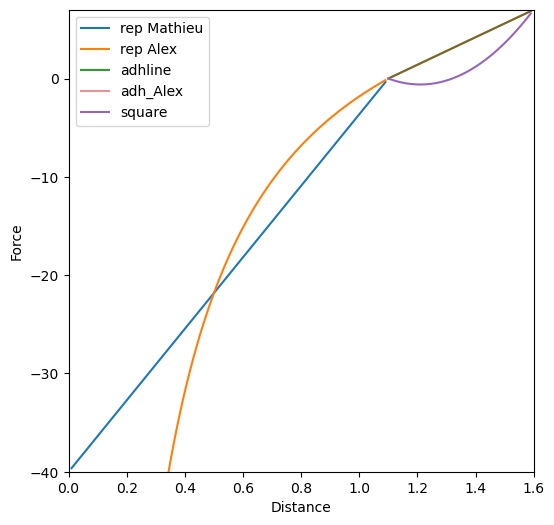

In [7]:
PLOT = False
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 2048 #1308 # Micrometers

# time settings
TIME_SIMU = 90 # time simulation in minutes
DELTA_T = 0.01 # 0.01 # 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 100 # 25

# simulation parameters
MU = 1 #1  # mobility in min.kg-1
F_REP = 40  # repulsive strength
F_ADH = 7 # 3 #4 #attractive strength force kg.um.min-2
R_EQ = 1.1 # 11  # equilibrium radius in um
R_0 = 1.6 # 16  # interaction radius in um
MIN_DISTANCE_INIT = R_EQ

# factor simulation
NOISE = 5 #10 # noise intensity
FLUCTUATION_FACTOR = 0 #4
TAU = 5 # 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
PERSISTENCE_POP1 = 0 #0.1
PERSISTENCE_POP2 = 0 #0.4

# Cells definition
PACKING_FRACTION = 0.00002
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
# N = 2000
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 3 #um/min
velocity_magnitude_pop2 = 6 # um/min

COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

In [8]:
# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=PERSISTENCE_POP1,\
                         min_distance=MIN_DISTANCE_INIT)

population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=PERSISTENCE_POP2,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

In [9]:
# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])

if PLOT : 
    PATH = f'/Users/souchaud/Desktop/simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
    if not os.path.exists(PATH):
        os.mkdir(PATH)
    else :
        print("WARNING : FOLDER DOES ALREADY EXIST!")
        sys.exit(0)
    plot_environment(cells, space_size= SPACE_SIZE, req=R_EQ,
                    path_saving=PATH, iteration = 0)

In [10]:
def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    
    Paramètres
    ----------
    dX : Tensor
        Le déplacement des cellules durant le dernier intervalle de temps.
    n : Tensor
        La direction actuelle des cellules.
    tau : float
        Le temps caractéristique pour l'alignement de la polarisation dans
        la direction définie par la vitesse = dX/dt.
    noise : float
        L'intensité du bruit ajouté pour simuler des perturbations aléatoires
        dans la direction des cellules.
    dt : float
        L'intervalle de temps entre les mises à jour des positions.
    persistence : float
        Le facteur de persistance qui influence à quel point la direction actuelle
        est conservée. Valeur entre 0 (pas de persistance, direction entièrement aléatoire)
        et 1 (persistance complète, pas de changement de direction).

    Retour
    -------
    new_direction : Tensor
        La nouvelle direction des cellules après mise à jour.
    """    
     # Normalize the input vector
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0]).to(device)
    
    # Compute the change in angle based on the orientation vector (n)
    dtheta = 0 * torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau # * (1 - persistence))

    # Generate random noise for angle perturbation
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) #* (1 - persistence)
    
    # Capture de theta avant sa mise à jour
    initial_theta = theta.clone()  # Utilisez clone() pour éviter les modifications inattendues
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta_update = initial_theta + dtheta + rnd.squeeze(1)

    # Calculate the weighted average of the new direction and the old direction
    new_dir_x = torch.cos(theta_update) #* (1 - persistence) + n[:, 0] * persistence
    new_dir_y = torch.sin(theta_update) #* (1 - persistence) + n[:, 1] * persistence
    
    # Créer un nouveau tenseur pour la direction mise à jour au lieu de modifier n
    new_direction = torch.stack((new_dir_x, new_dir_y), dim=1)
    
    # Retourne la nouvelle direction, rnd, dtheta, et initial_theta
    return new_direction

In [11]:
        # if abs(angle) > 1.5:
        #     print("Pop1", i, "direct", cell.direction, "newdire", new_direction,
        #           "angle", angle, "disp", cell_displacement, "init theta", initial_theta,
        #           "random", rnd)
        #     fig, ax = plt.subplots(figsize=(6, 6))
        #     # Cercle unitaire
        #     circle = plt.Circle((0, 0), 1, color='blue', fill=False)
        #     ax.add_artist(circle)
        #     # Ajouter les vecteurs
        #     for direction, color, label in zip([cell.direction.unsqueeze(0), new_direction], ['red', 'green'], ['n', 'new_direction']):
        #         ax.quiver(0, 0, direction[0, 0], direction[0, 1], angles='xy', scale_units='xy', scale=1, color=color, label=label)
        #     # Configuration du graphique
        #     ax.set_xlim(-1.5, 1.5)
        #     ax.set_ylim(-1.5, 1.5)
        #     ax.set_aspect('equal')
        #     plt.xlabel('X')
        #     plt.ylabel('Y')
        #     plt.title('Vecteurs sur un cercle trigonométrique')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

In [12]:
# # In[Simulation]

# # Création du DataFrame vide
# columns = ['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y']
# data_frame = pd.DataFrame(columns=columns)
# time = 0
# iteration = 1
# MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

# while time < TIME_SIMU :
#     #Paiwise distance.
#     coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
#     coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
#     distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
#                              for i in range(0, len(coordinates_diff))])
#     is_greater_than_max = torch.any(distances > MAX_DISTANCE)

#     if is_greater_than_max:
#       print("At least one distance is greater than the max distance.")

#     # force_field calculation
#     force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
#                                     R0=R_0, Frep=F_REP, Fadh=F_ADH,
#                                     coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    
#     # displacement computing
#     fluctuations = (torch.rand(V0.shape, device=V0.device) - 0.5) * FLUCTUATION_FACTOR
#     displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * direction * DELTA_T
#     positions += displacement

#     # border conditions
#     positions = torch.remainder(positions, SPACE_SIZE)

#     for cell, position in zip(cells, positions) : #, direction):
#         cell.position = position.to(device)
#         # cell.direction = direct.to(device)
#         # print(cell, position, direct)
        
#     for i, cell in enumerate(population1.cells):
#         # Extraire le vecteur déplacement spécifique à cette cellule
#         cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
#         # Appeler autovel et récupérer la nouvelle direction et l'angle
#         new_direction = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
#         angle = torch.arctan2(cell.direction[1],cell.direction[0]) - torch.arctan2(new_direction.squeeze(0)[1],new_direction.squeeze(0)[0])
#         if angle > np.pi: 
#             angle = angle - 2 * np.pi
#         if angle < -np.pi:
#             angle = angle + 2 * np.pi
#          # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
#         cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue

#     # Faire de même pour la population 2
#     # Correction pour population2 : Commencer l'indexation de displacement là où population1 se termine
#     offset = len(population1.cells)  # Ceci est le décalage (offset) pour commencer l'indexation des cellules de population2
#     for i, cell in enumerate(population2.cells):
#         # Utiliser i + offset pour accéder au bon élément de displacement
#         cell_displacement = displacement[i + offset, :].unsqueeze(0)
#         # Appeler autovel et récupérer la nouvelle direction et l'angle
#         new_direction = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
#         angle = torch.arctan2(cell.direction[1],cell.direction[0]) - torch.arctan2(new_direction.squeeze(0)[1],new_direction.squeeze(0)[0])
#         if angle > np.pi: 
#             angle = angle - 2 * np.pi
#         if angle < -np.pi:
#             angle = angle + 2 * np.pi
#         # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
#         cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue

#     # plot the result
#     if PLOT:
#         marker_radius = 1.1
#         marker_size = (np.pi) * marker_radius ** 2
#         if iteration % PLOT_INTERVAL == 0:
#             plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

#     # À la fin de chaque itération de la boucle, enregistrez les coordonnées et les directions
#     temp_data = []
#     for i, cell in enumerate(cells):
#         temp_data.append([
#             time, i, cell.position[0].item(), cell.position[1].item(), 
#             cell.direction[0].item(), cell.direction[1].item()
#             # Enregistrez les nouvelles valeurs ici
#         ])

#     temp_df = pd.DataFrame(temp_data, columns=['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y'])
#     data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

#     # Après avoir mis à jour toutes les cellules
#     direction = torch.stack([cell.direction for cell in cells])
#     # Mise à jour du temps
#     time += DELTA_T
#     # print(time)
#     iteration += 1

In [13]:
# In[Simulation]

# Création du DataFrame vide
columns = ['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y']
data_frame = pd.DataFrame(columns=columns)
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)
# Création du DataFrame vide à la fin, initialisation de la liste temporaire pour stocker les données
data_list = []

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")

    # force_field calculation
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    
    # displacement computing
    fluctuations = (torch.rand(V0.shape, device=V0.device) - 0.5) * FLUCTUATION_FACTOR
    displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * direction * DELTA_T
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    # Mise à jour de la position et de la direction pour chaque cellule
    for cell, disp in zip(cells, displacement):
        # Mise à jour de la position de la cellule
        cell.position += disp
        cell.position = torch.remainder(cell.position, SPACE_SIZE)
        
        # Mise à jour de la direction de la cellule
        new_direction = autovel(disp.unsqueeze(0), cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        cell.direction = new_direction.squeeze(0)
        # Ajouter les informations de la cellule à la liste temporaire
        data_list.append({
            'frame': time,
            'particle': cell.id,
            'x': cell.position[0].item(),
            'y': cell.position[1].item(),
            'dir_x': cell.direction[0].item(),
            'dir_y': cell.direction[1].item()
        })

    # plot the result
    if PLOT:
        marker_radius = 1.1
        marker_size = (np.pi) * marker_radius ** 2
        if iteration % PLOT_INTERVAL == 0:
            plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

    # À la fin de chaque itération de la boucle, enregistrez les coordonnées et les directions
    temp_data = []
    for i, cell in enumerate(cells):
        temp_data.append([
            time, i, cell.position[0].item(), cell.position[1].item(), 
            cell.direction[0].item(), cell.direction[1].item()
            # Enregistrez les nouvelles valeurs ici
        ])

    temp_df = pd.DataFrame(temp_data, columns=['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y'])
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

    # Après avoir mis à jour toutes les cellules
    direction = torch.stack([cell.direction for cell in cells])
    # Mise à jour du temps
    time += DELTA_T
    # print(time)
    iteration += 1

    # Création du DataFrame à partir de la liste temporaire après la boucle
data_frame = pd.DataFrame(data_list)

AttributeError: 'CellAgent' object has no attribute 'id'

In [ ]:
def adjust_positions_xy(group, dt, space_size):
    SPACE_SIZE_X = space_size  # La taille de l'espace toroïdal en x
    SPACE_SIZE_Y = space_size  # La taille de l'espace toroïdal en y, ajustez selon votre espace
    # Calculer les différences pour obtenir 'dx' et 'dy'
    group['dx'] = group['x'].diff().fillna(0)
    group['dy'] = group['y'].diff().fillna(0)
    
    # Initialiser de nouvelles colonnes pour les positions ajustées
    group['adjusted_x'] = group['x'].copy()
    group['adjusted_y'] = group['y'].copy()
    
    # Ajuster les positions en x
    for i in range(1, len(group)):
        if group.iloc[i]['dx'] > SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] -= SPACE_SIZE_X
        elif group.iloc[i]['dx'] < -SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] += SPACE_SIZE_X
            
    # Ajuster les positions en y
    for i in range(1, len(group)):
        if group.iloc[i]['dy'] > SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] -= SPACE_SIZE_Y
        elif group.iloc[i]['dy'] < -SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] += SPACE_SIZE_Y
            
    # Calculer dx et dy ajustés après correction
    # group['adjusted_dx'] = group['adjusted_x'].diff().fillna(0)
    # group['adjusted_dy'] = group['adjusted_y'].diff().fillna(0)
    group['dx'] = group['adjusted_x'].diff().fillna(0)
    group['dy'] = group['adjusted_y'].diff().fillna(0)
    group['x'] = group['adjusted_x']
    group['y'] = group['adjusted_y']
    group.drop(['adjusted_x', 'adjusted_y'], axis=1, inplace=True)

    # Calculer la distance parcourue à chaque pas de temps
    group['distance'] = (group['dx']**2 + group['dy']**2).pow(0.5)

    # Calculer la vitesse pour chaque pas de temps
    group['vitesse'] = group['distance'] / dt

    return group

# Appliquer la fonction à chaque groupe de particules en utilisant lambda pour inclure DELTA_T comme argument dt
df_adjusted = data_frame.groupby('particle').apply(lambda group: adjust_positions_xy(group, dt=DELTA_T, space_size=SPACE_SIZE)).reset_index(drop=True)

# Calculer la vitesse moyenne pour chaque particule
vitesse_moyenne = df_adjusted.groupby('particle')['vitesse'].mean()

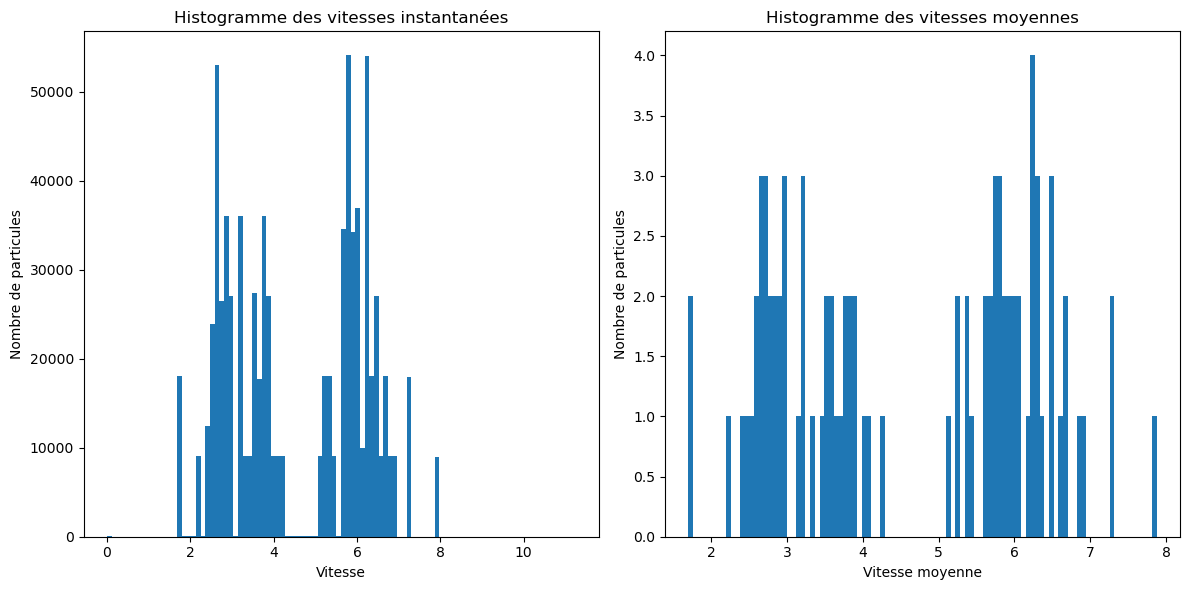

In [ ]:
# Créer une figure et deux subplots (axes) sur une grille de 1x2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # La figure a 1 ligne et 2 colonnes de graphiques

# Tracer le premier histogramme sur le premier axe (panneau)
axs[0].hist(df_adjusted['vitesse'], bins = 100)
axs[0].set_title('Histogramme des vitesses instantanées')
axs[0].set_xlabel('Vitesse')
axs[0].set_ylabel('Nombre de particules')

# Calculer la vitesse moyenne pour chaque particule si pas déjà fait
# vitesse_moyenne = df_adjusted.groupby('particle')['vitesse'].mean()

# Tracer le second histogramme sur le second axe (panneau)
axs[1].hist(vitesse_moyenne, bins=100)
# axs[1].set_xlim(4, 6)  # Décommentez et ajustez si nécessaire
axs[1].set_title('Histogramme des vitesses moyennes')
axs[1].set_xlabel('Vitesse moyenne')
axs[1].set_ylabel('Nombre de particules')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement des titres et des étiquettes
plt.tight_layout()

# Afficher la figure contenant les deux subplots
plt.show()


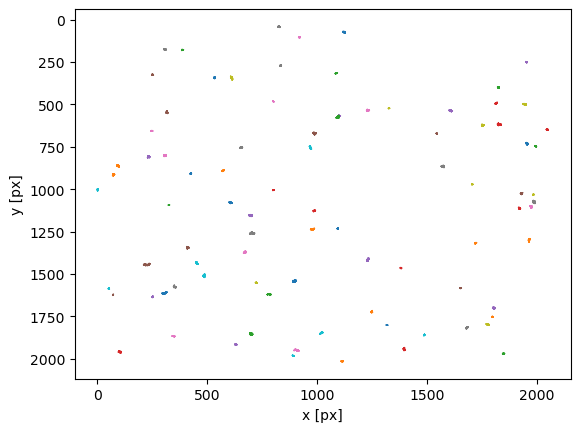

In [ ]:
fig, ax = plt.subplots()
tp.plot_traj(traj=df_adjusted)
# Rendre les échelles des axes x et y égales
ax.set_aspect('equal', 'box')
# Ajouter un titre
ax.set_title('Trajectory of Particle 1')
plt.show()

In [ ]:
# Fonction pour calculer l'angle en degrés entre deux vecteurs de direction successifs
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    if angle_change > np.pi : 
        angle_change = angle_change - 2 * np.pi
    if angle_change < -np.pi:
        angle_change = angle_change + 2 * np.pi

    return angle_change
#     # return np.degrees(angle_change)  # Convert angle to degrees
#     # Calculate the angle difference
#     angle_change = np.arccos(dx1*dx2+dy1*dy2)
#     # Normalize the angle to be between -pi and pi
#     # angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
df = df_adjusted.copy()
# Assurez-vous que votre DataFrame est trié par particule et par frame
df.sort_values(by=['particle', 'frame'], inplace=True)

# Décaler les directions pour obtenir le vecteur direction au temps t+1 pour chaque particule
df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)

# Appliquer la fonction pour calculer l'angle entre les directions successives
df['angle_change'] = df.apply(angle_between_directions, axis=1)

# Optionnel : Supprimer les lignes où la direction suivante est NaN, ce qui se produit pour la dernière observation de chaque particule
df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

# Afficher le résultat
# print(df[['frame', 'particle', 'dir_x', 'dir_y', 'dir_x_next', 'dir_y_next', 'angle_change']])


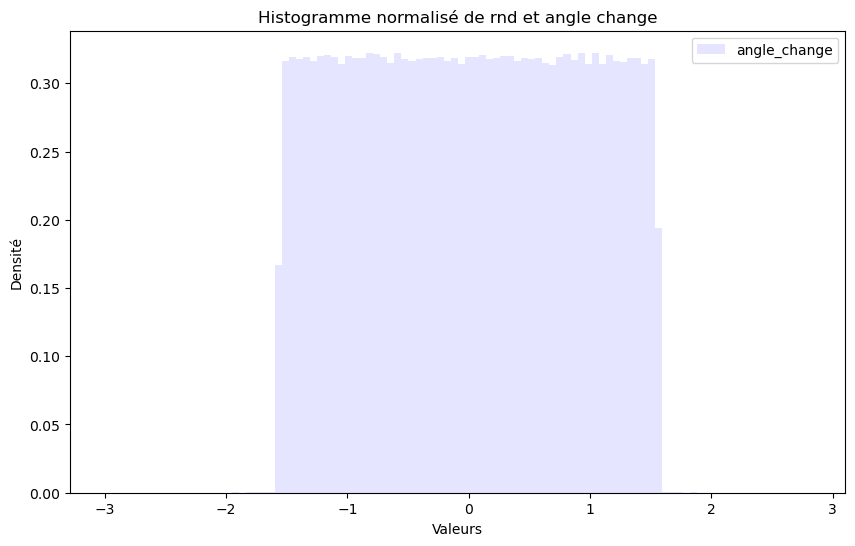

In [ ]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))
# Tracer l'histogramme pour 'angle_change' (normalisé)
plt.hist(df['angle_change'], bins=100, alpha=0.1, color='blue', label='angle_change', density=True)
# Ajouter une légende
plt.legend()
# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de rnd et angle change')
# Afficher la figure
plt.show()

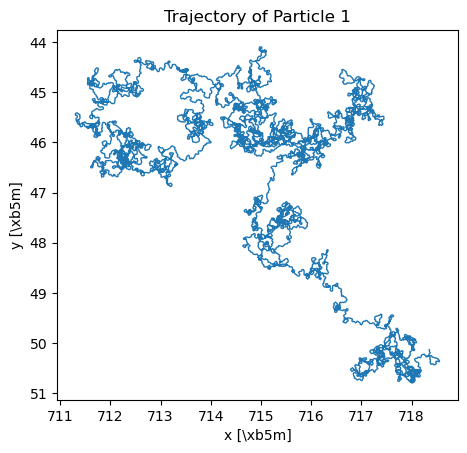

In [ ]:
# Supposons que df_adjusted est votre DataFrame après ajustements avec 'particle', 'x', et 'y'
particle_df = df_adjusted[df_adjusted['particle'] == 0]
fig, ax = plt.subplots()
tp.plot_traj(particle_df, mpp=0.637, fps=1, ax=ax)
# Rendre les échelles des axes x et y égales
ax.set_aspect('equal', 'box')
# Ajouter un titre
ax.set_title('Trajectory of Particle 1')
plt.show()

In [ ]:
df_msd = df_adjusted.copy()
df_msd['frame'] = df_msd.groupby('particle').cumcount() + 1


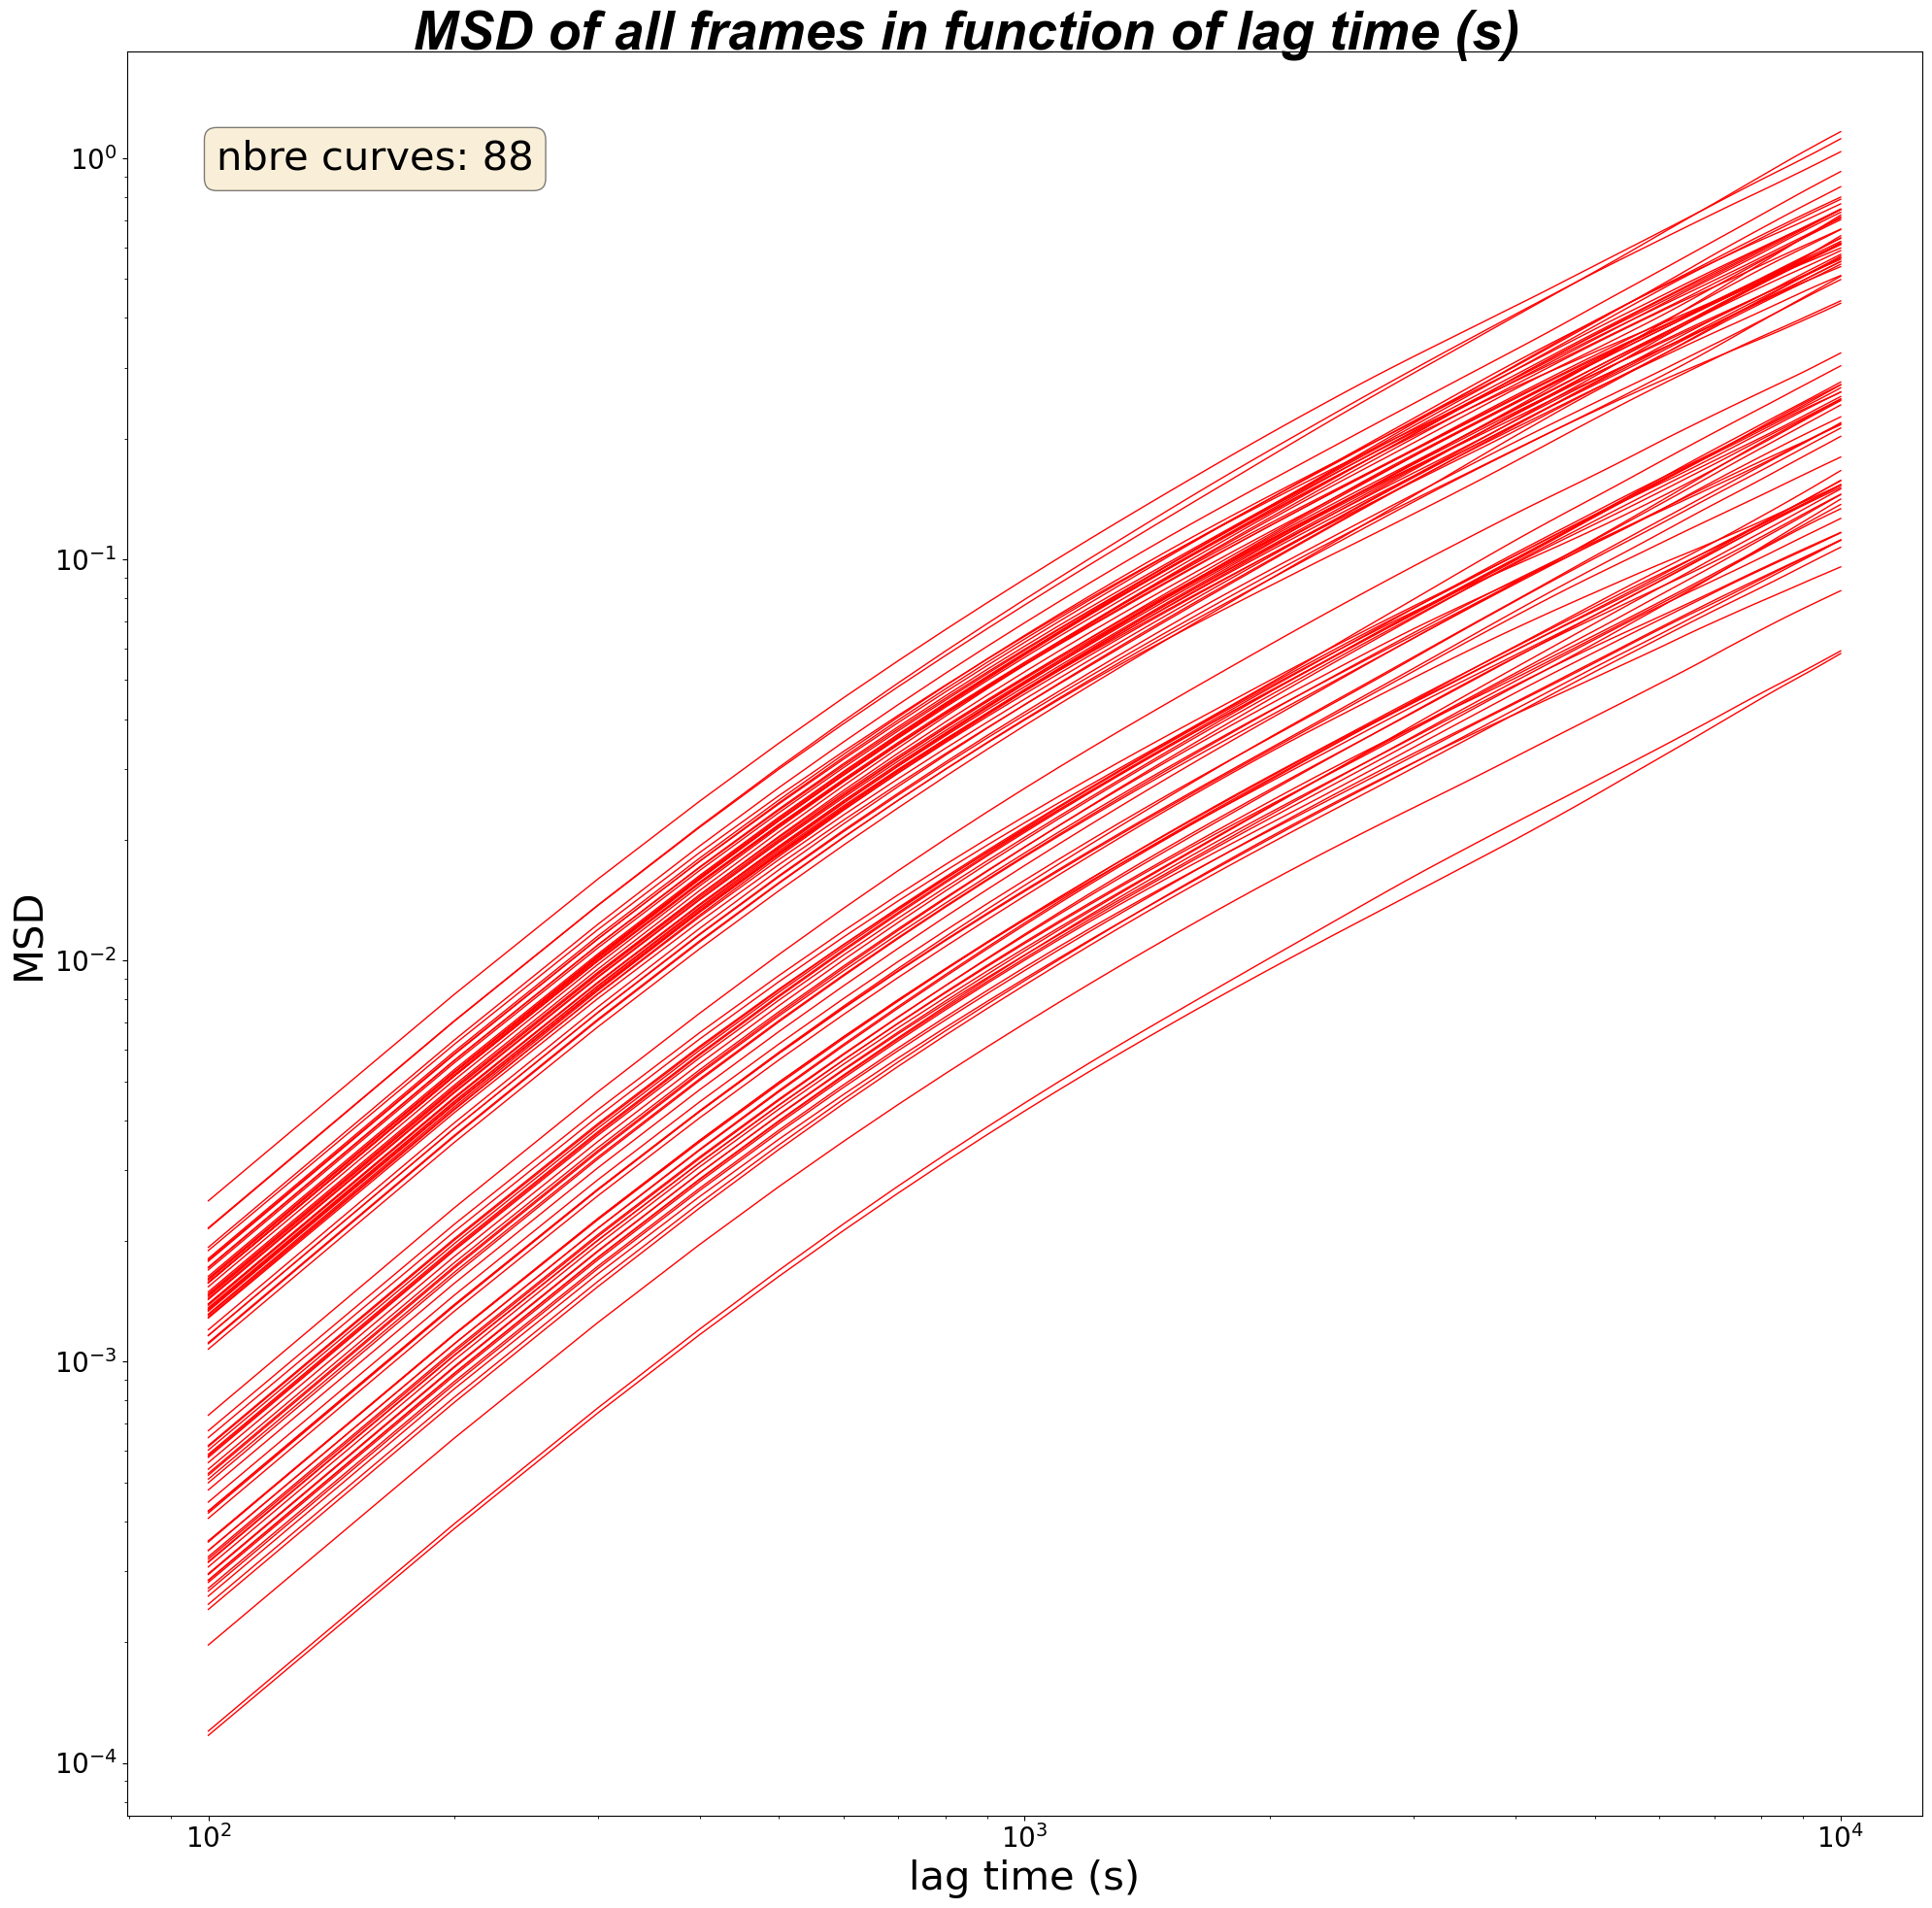

In [ ]:
def plot_msd(msd, fps, name="MSD of all frames in function of lag time (s)",
             color_plot: str = 'red', save=False, pathway_saving=None,
             alpha=0.05, linewidth=0.01, img_type='jpg'):
    """
    Plot the mean square displacement (MSD) for a specific need.

    Parameters
    ----------
    msd : DataFrame
        DataFrame containing the MSD values.
    fps : float
        Number of frames per second.
    name : str, optional
        Title of the plot. Default is "MSD of all frames in function of lag time (s)".
    save : bool, optional
        Whether to save the plot or not. Default is False.
    pathway_saving : str, optional
        Absolute path to save the plot. Default is None.

    Returns
    -------
    None.

    """
    # Get the number of curves from the number of columns in the MSD DataFrame
    nbr_curves = len(msd.columns)

    # # Set the index
    # msd = msd.set_index("lag time [s]")

    # Create a new figure and axis object
    fig, axis = plt.subplots(figsize=(20, 20))

    # Plot the MSD data on the axis object
    axis.plot(msd, alpha=alpha, linewidth=linewidth, color=color_plot)

    # Set the limits of the x-axis and y-axis
    # axis.set_xlim([1 / fps, 100 / fps])
    # axis.set_ylim(0.01, 10000)

    # Set the x-axis and y-axis to be on a log scale
    axis.set(xscale="log", yscale="log")

    # Set the x-axis label
    axis.set_xlabel("lag time (s)", fontsize=30)

    # Set the x-axis label
    axis.set_ylabel("MSD", fontsize=30)

    # Add a text box to the plot with the number of curves
    textstr = f"nbre curves: {nbr_curves}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    axis.text(0.05, 0.95, textstr, transform=axis.transAxes, fontsize=30,
              verticalalignment="top", bbox=props)

    axis.tick_params(axis='both', which='major', labelsize=20)

    # Set the title of the plot
    fig.suptitle(name, fontsize=40, fontweight="bold", fontstyle='italic', fontname="Arial")

    # Adjust the spacing of the plot
    fig.tight_layout()

    # Save the plot if the "save" parameter is True
    if save:
        fig.savefig(f"{pathway_saving}{name}." + img_type, format=img_type)


IMSD = tp.imsd(df_msd, mpp = 0.637, fps = 0.01)


plot_msd(IMSD, fps=0.01, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=1, linewidth=1, img_type='jpg')

# negative slope 0


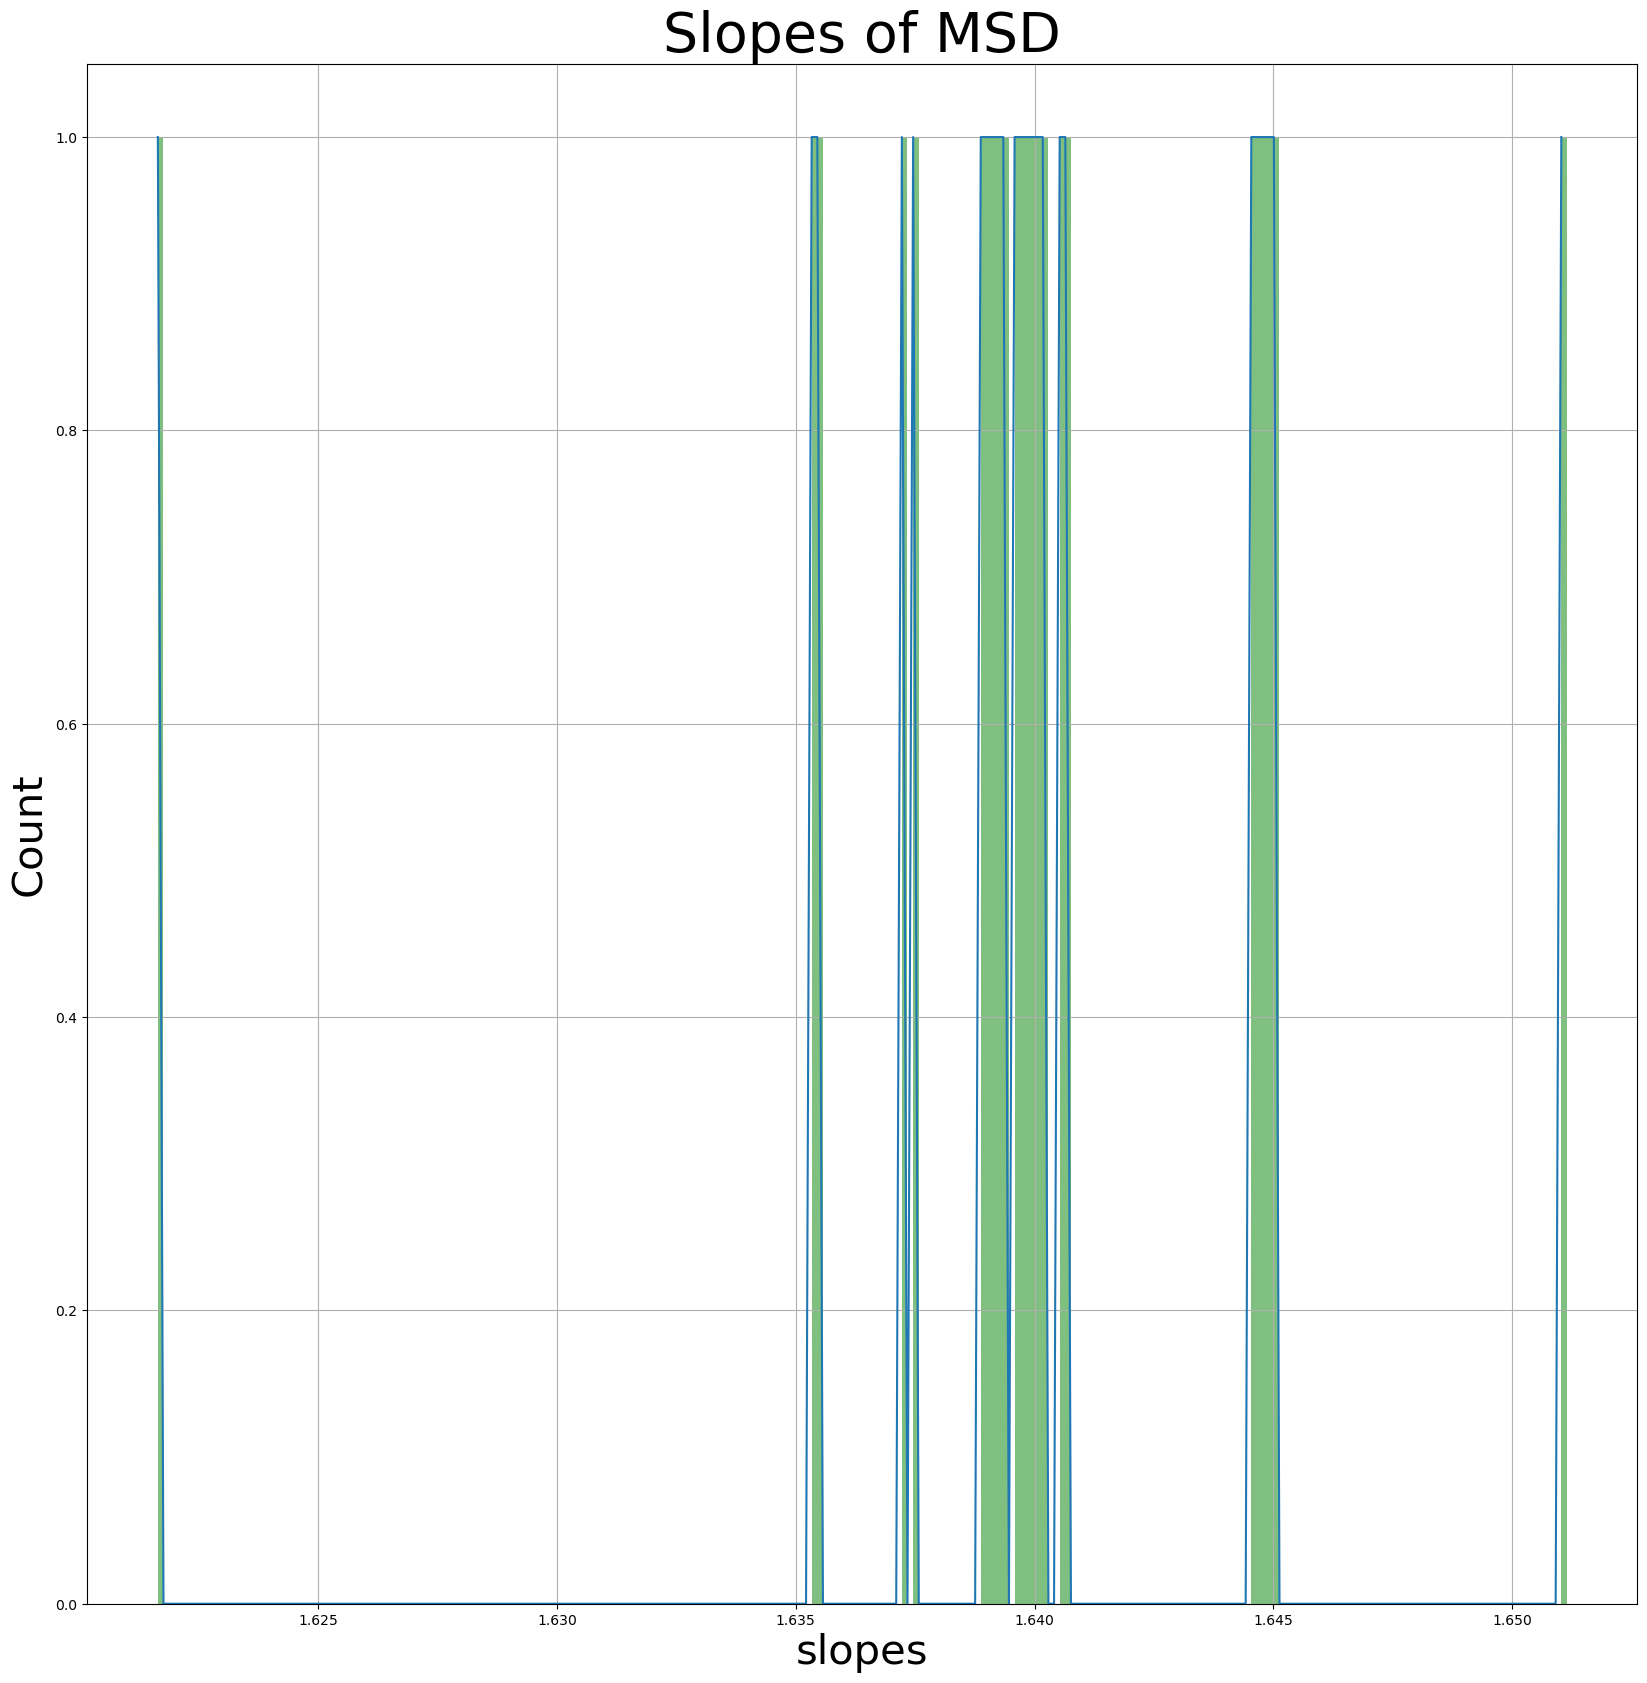

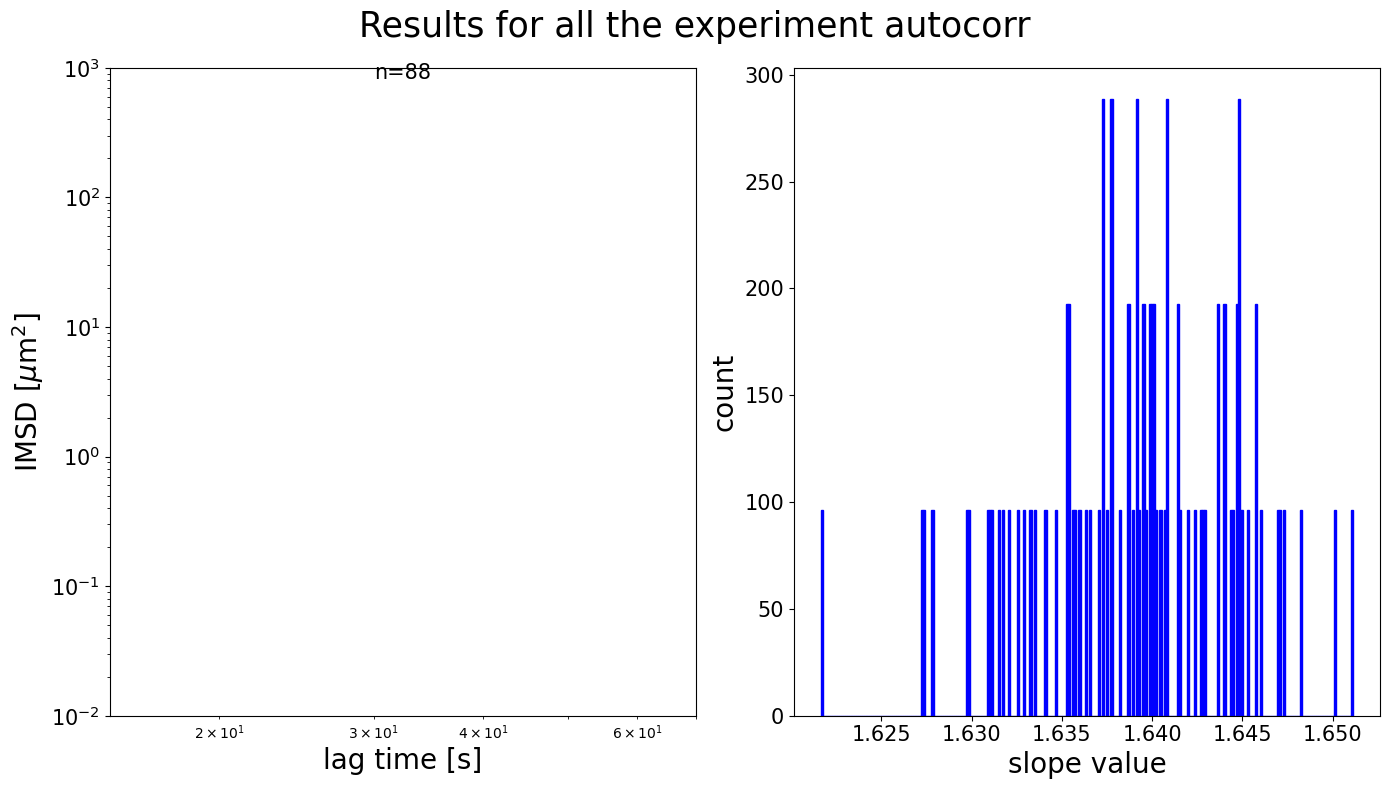

In [ ]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
   lib.traj_clustering_with_fit_cutoff(df_adjusted, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=0.637,
                                        fps=0.01, binsize=250,
                                        peak_height=50, peak_width=1,
                                        save=False, pathway_fig=None,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=1.4
                                        )

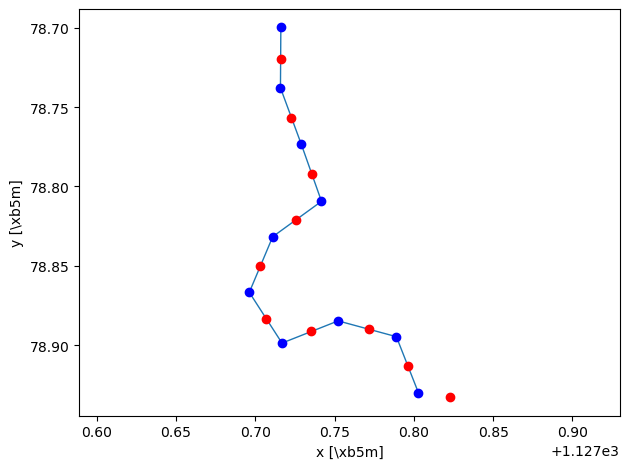

In [ ]:
# Filtrer le DataFrame pour une particule spécifique
particle_df = df_adjusted[df_adjusted['particle'] == 0].iloc[0:10]
particle_df['normdxdy'] = (particle_df['dir_x']**2 + particle_df['dir_y']**2)**0.5
fig, ax = plt.subplots()
# Tracer la trajectoire de la particule
tp.plot_traj(particle_df, mpp=1, fps=15/60, ax = ax)
# Obtenir l'axe actuel
ax = plt.gca()

# Pour chaque point de la trajectoire, ajouter un point représentant la direction
for index, row in particle_df.iterrows():
    # Le point de départ du point (position de la particule)
    
    # Calculer la position du point de direction (en ajoutant un facteur d'échelle aux composantes de direction si nécessaire)
    dir_x = row['x'] + row['dir_x']*0.02   # Facteur d'échelle pour déterminer la position du point de direction
    dir_y = row['y'] + row['dir_y']*0.02  # Facteur d'échelle pour déterminer la position du point de direction
    ax.plot(row['x'], row['y'], 'bo')  # 'ro' crée un point rond rouge
    # Ajouter le point de direction au graphique
    ax.plot(dir_x, dir_y, 'ro')  # 'ro' crée un point rond rouge

# Afficher le graphique
# Assurer les mêmes échelles en x et y
ax.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
df

,frame,particle,x,y,dir_x,dir_y,dx,dy,distance,vitesse
0,0,0,1127.716064,78.699715,-0.006493,0.999979,0.000000,0.000000,0.000000,0.000000
1,0.01,0,1127.715820,78.737762,0.345114,0.938561,-0.000244,0.038048,0.038049,3.804857
2,0.02,0,1127.729004,78.773476,0.332845,0.942981,0.013184,0.035713,0.038069,3.806888
3,0.03,0,1127.741699,78.809357,-0.809828,0.586668,0.012695,0.035881,0.038061,3.806074
4,0.04,0,1127.710938,78.831680,-0.386957,0.922098,-0.030762,0.022324,0.038008,3.800825
...,...,...,...,...,...,...,...,...,...,...
791995,89.95,87,1570.451294,863.197266,0.858656,-0.512552,0.035278,-0.052734,0.063447,6.344662
791996,89.96,87,1570.505737,863.164734,0.840939,0.541130,0.054443,-0.032532,0.063422,6.342234
791997,89.97,87,1570.559082,863.199036,0.999227,-0.039302,0.053345,0.034302,0.063421,6.342137
791998,89.98,87,1570.622437,863.196533,0.793801,-0.608177,0.063354,-0.002502,0.063404,6.340389


In [ ]:
# Fonction pour calculer l'angle en degrés entre deux vecteurs de direction successifs
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    # Normalize the angle to be between -pi and pi
    angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))

    return angle_change

df = df_adjusted.copy()
# Assurez-vous que votre DataFrame est trié par particule et par frame
df.sort_values(by=['particle', 'frame'], inplace=True)
# Décaler les directions pour obtenir le vecteur direction au temps t+1 pour chaque particule
df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)
# Appliquer la fonction pour calculer l'angle entre les directions successives
df['angle_change'] = df.apply(angle_between_directions, axis=1)
# Optionnel : Supprimer les lignes où la direction suivante est NaN, ce qui se produit pour la dernière observation de chaque particule
df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)


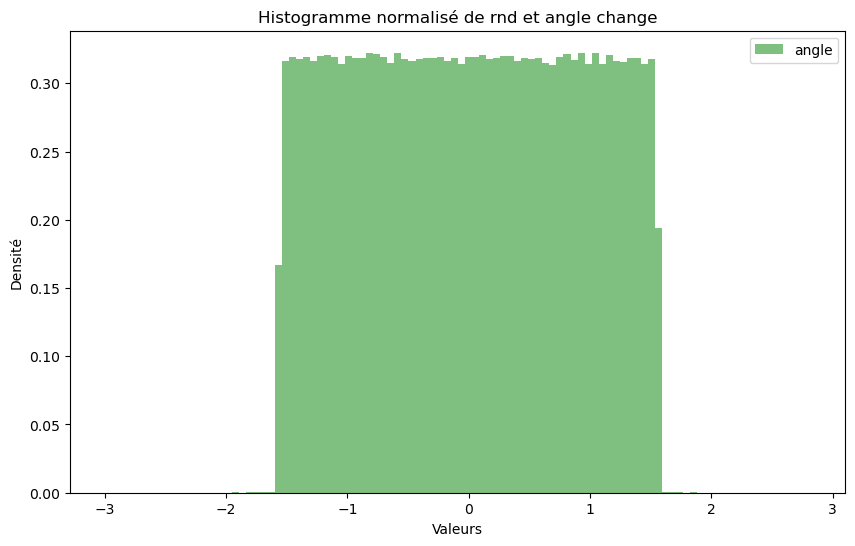

In [ ]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))
# Tracer l'histogramme pour 'angle_change' (normalisé)
plt.hist(df['angle_change'], bins=100, alpha=0.5, color='green', label='angle', density=True)
# Ajouter une légende
plt.legend()
# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de rnd et angle change')
# Afficher la figure
plt.show()